# Example

In [1]:
import torch
import sys
sys.path.append('C:/Users/lewa/Documents/PhD/vit/vit-pytorch/')
sys.path.append('C:/Users/lewa/Documents/PhD/vit/mae/')
import models_mae
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
#autoreload python file
%reload_ext autoreload
%autoreload 2

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


def show_image(image, title=''):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])  
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    print(mask.shape)
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/mae_visualize_vit_large_ganloss.pth'
chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/PACS-photo-rand/checkpoint.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

run_one_image(img, model_mae)

c:\Users\lewa\Anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>


AttributeError: 'MaskedAutoencoderViT' object has no attribute 'MLPmasking'

In [ ]:
chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/sketch/sketch.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
img_url = 'https://pic2.zhimg.com/80/v2-638f7800c7ba3c03d4dc4541c4938961_1440w.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = Image.open('../../dataset/PACS/kfold/sketch/horse/8484.png')
img = img.resize((224, 224))
img = np.array(img) / 255.

run_one_image(img, model_mae)

torch.Size([1, 196])


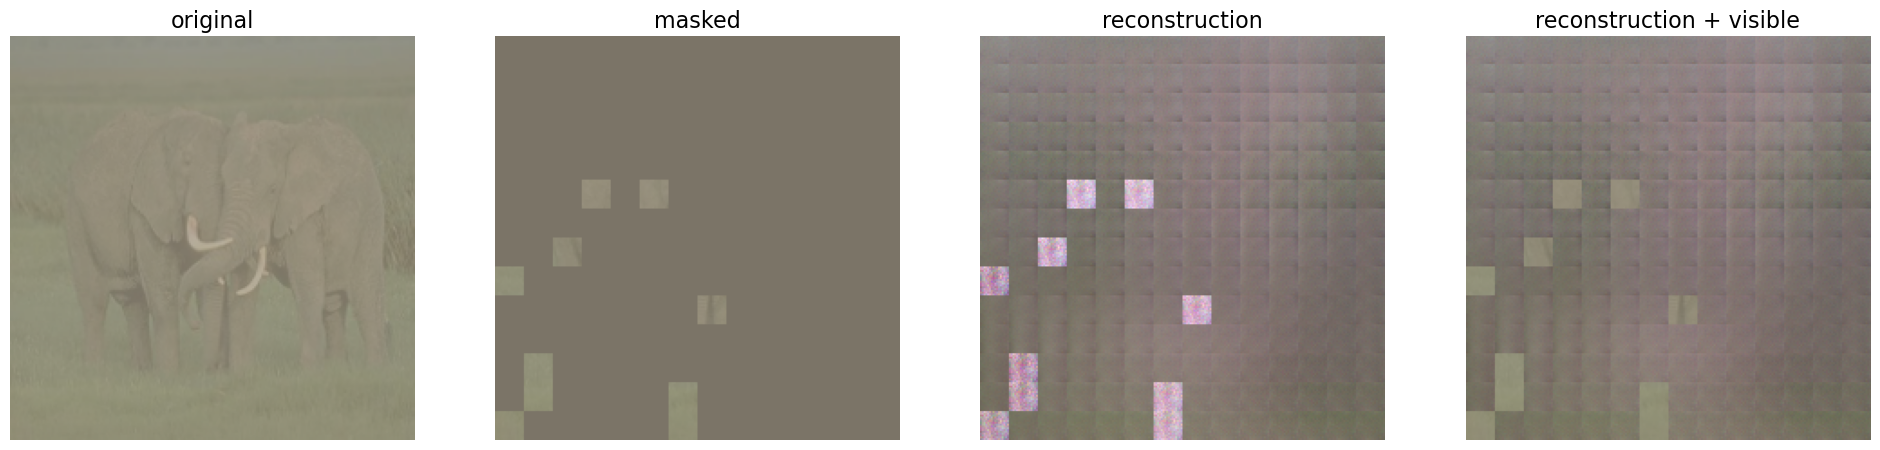

In [19]:
img = Image.open('../../dataset/PACS/kfold/photo/elephant/064_0003.jpg')
img = img.resize((224, 224))
img = np.array(img) / 255.
run_one_image(img, model_mae)


# Masking test

In [34]:
x = torch.tensor(img) #(224, 224, 3)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = noise = torch.rand(64,224,224,3, device=x.device)
x = torch.einsum('nhwc->nchw', x)
# x = model_mae.patch_embed(x.float())
# x = x + model_mae.pos_embed[:, 1:, :]
x = model_mae.patchify(x)  #[1, 196, 1024]
N, L, D = x.shape
print(x.shape)
feat = torch.rand(N, L, device=x.device)
mask_tmp = torch.round(feat)
print(feat.shape,mask_tmp.shape)

torch.Size([64, 196, 768])
torch.Size([64, 196]) torch.Size([64, 196])


In [76]:
dummy_target = torch.zeros(feat.shape,device=x.device)

In [69]:
feat

tensor([[0.5204, 0.3484, 0.0685,  ..., 0.0022, 0.1416, 0.2151],
        [0.9418, 0.1222, 0.4053,  ..., 0.9949, 0.7509, 0.0251],
        [0.9660, 0.7261, 0.5326,  ..., 0.8591, 0.5655, 0.1826],
        ...,
        [0.9861, 0.4491, 0.3821,  ..., 0.5940, 0.5442, 0.9967],
        [0.9736, 0.2870, 0.0896,  ..., 0.8955, 0.4386, 0.8013],
        [0.5778, 0.1681, 0.6921,  ..., 0.6999, 0.4065, 0.2200]])

In [83]:
import torch.nn.functional as F 
with torch.cuda.amp.autocast(enabled=False):
    l=F.binary_cross_entropy(feat.float(), dummy_target.float())
print(l)

tensor(1.0147)


In [60]:
max(196-mask_tmp.sum(axis=1))

tensor(111.)

In [58]:
mask_tmp.sum(axis=1).max()

tensor(115.)

In [22]:
print(mask_tmp.shape)

torch.Size([1, 196])


In [26]:
sum(mask_tmp,dim = 0)

TypeError: 'dim' is an invalid keyword argument for sum()

In [19]:
int(sum(mask_tmp).min())

0

## PCAmasking

## MLPmasking

In [117]:
feat[:,:98]=1
feat[:,98:] =0

In [169]:
tmp = torch.sort(feat,dim=1)[0]
tmp[:,len_keep]
tmp[tmp ]

tensor([0.2757])

In [170]:
ids_restore = torch.argsort(feat, dim=1)
ids_keep = ids_restore[:, :len_keep]
x_masked = x*(1-mask_tmp).unsqueeze(-1).repeat(1, 1, D)
x_masked = torch.gather(x_masked, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
# x_masked = torch.sort(x_masked,dim=1,descending=False)[0][:, :len_keep,:]

In [144]:
tmp = torch.tensor([[1, 2, 3], [4,5,6]]).unsqueeze(-1).repeat(1, 1, 2)
tmp.shape

torch.Size([2, 3, 2])

In [130]:
x_masked

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8549, 0.9176, 0.7412,  ..., 0.8549, 0.9176, 0.7490],
         [0.8510, 0.9176, 0.7412,  ..., 0.8510, 0.9176, 0.7490],
         [0.8471, 0.9176, 0.7412,  ..., 0.8510, 0.9176, 0.7490]]],
       dtype=torch.float64)

In [121]:
len_keep=49
ids_restore = torch.argsort(feat, dim=1)
ids_keep = ids_restore[:, :len_keep]
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D)) #选取其中多个且乱序的值
mask = torch.ones([N, L], device=x.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)

In [109]:
print(mask.shape)

torch.Size([1, 196])


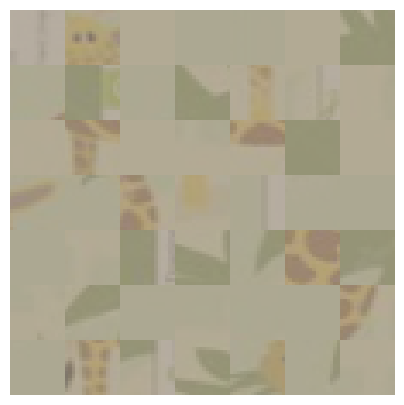

In [171]:
x_masked_un = model_mae.unpatchify(x_masked)
x_masked_un = torch.einsum('nchw->nhwc', x_masked_un).detach().cpu()
x_masked_un.shape
plt.figure(figsize=(5,5))
show_image(x_masked_un[0])

In [119]:
mask = mask.unsqueeze(-1).repeat(1, 1, model_mae.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
print(mask.shape)

torch.Size([1, 196, 768])


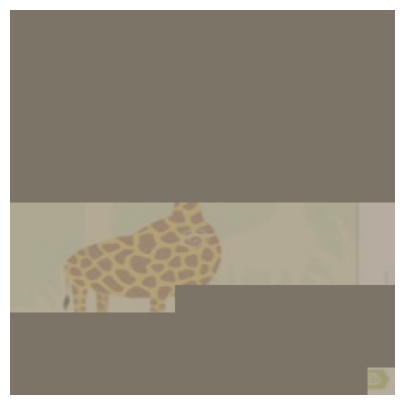

In [120]:
mask = model_mae.unpatchify(mask)
im_masked = model_mae.unpatchify(x) * (1 - mask)
im_masked = torch.einsum('nchw->nhwc', im_masked)
plt.figure(figsize=(5,5))
show_image(im_masked[0])

SystemExit: 

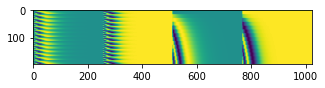

In [20]:
plt.figure(figsize=(5,5))
x = torch.tensor(img)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)

In [8]:
mask.shape

torch.Size([1, 196])

In [2]:
import torch
torch.cuda.is_available()

True

Test

In [16]:
noise = torch.rand(3, 6)
ids_shuffle = torch.argsort(noise, dim=1) 
torch.argsort(ids_shuffle, dim=1)

tensor([[3, 5, 2, 4, 0, 1],
        [3, 5, 1, 4, 2, 0],
        [2, 1, 3, 0, 5, 4]])

# Training

In [ ]:
import main_pretrain
main()

In [ ]:
!python .\mae\main_pretrain.py --data_path 'C:/Users/lewa/Documents/PhD/dataset/PACS/kfold/photo' --output_dir 'C:/Users/lewa/Documents/PhD/Models'

python .\mae\main_finetune.py --data_path 'C:/Users/lewa/Documents/PhD/dataset/PACS/kfold/sketch' --output_dir 'C:/Users/lewa/Documents/PhD/Models/sketch' --nb_classes 7 --resume 'C:/Users/lewa/Documents/PhD/Models/sketch/sketch.pth'

In [ ]:
! nvidia-smi

In [67]:
tensor_0 = torch.arange(0, 18).view(3, 3,2)
mask = torch.randn(3,3).ge(0.5)
mask = torch.tensor([[1,0,0],[0,0,1],[1,0,1]]).ge(0.5)
print(tensor_0,mask)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]]) tensor([[ True, False, False],
        [False, False,  True],
        [ True, False,  True]])


In [65]:
out = torch.tensor([[1,0],[2,7]])
print(torch.masked_select(tensor_0,mask,out=out))

tensor([0, 5, 6, 8])


C:\Users\lewa\AppData\Local\Temp\ipykernel_29344\2863936137.py:2: UserWarning: An output with one or more elements was resized since it had shape [2, 2], which does not match the required output shape [4]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  print(torch.masked_select(tensor_0,mask,out=out))


In [71]:
torch.tensor([[1,0,0],[0,0,1],[1,0,1]])

tensor([[1, 0, 0],
        [0, 0, 1],
        [1, 0, 1]])

In [70]:
tensor_0*mask.unsqueeze(-1).repeat(1, 1, 2)

tensor([[[ 0,  1],
         [ 0,  0],
         [ 0,  0]],

        [[ 0,  0],
         [ 0,  0],
         [10, 11]],

        [[12, 13],
         [ 0,  0],
         [16, 17]]])

In [54]:
mask.unsqueeze(-1).shape

torch.Size([3, 3, 1])

In [13]:
import torch
x = torch.ones((64,196,1024))
N, L, D = x.shape  # batch, length, dim
len_keep = int(L * (1 - .75))

noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
#(64,196)

# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1) #返回排序后的值所对应原a的下标
print(ids_shuffle)
print(ids_restore.shape)
# keep the first subset
ids_keep = ids_shuffle[:, :len_keep]
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D)) #选取其中多个且乱序的值
print(x_masked.shape)
# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L], device=x.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)
print(mask.shape)
print(mask)

tensor([[ 12, 168, 192,  ...,  54, 157, 129],
        [122,  29, 179,  ...,  76, 154,  85],
        [145, 153,  38,  ..., 114, 136,  50],
        ...,
        [ 47,  63, 143,  ..., 108,  73, 154],
        [ 29, 150,  19,  ..., 154, 178, 149],
        [130, 192,  19,  ..., 140,  23,  89]])
torch.Size([64, 196])
torch.Size([64, 49, 1024])
torch.Size([64, 196])
tensor([[0., 1., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.]])


In [72]:

np.ones((4,4)).sum()

NameError: name 'np' is not defined